# Concept Detection Analysis and Model Comparison Lab Notebook
## Introduction

This final lab notebook completes our analysis of concept detection in synthetic academic abstracts by evaluating how accurately different large language models can identify and extract conceptual content from our controlled dataset. 

Our analysis examines four key dimensions of performance:

- **Topic Identification Accuracy**: How well can models identify the primary academic disciplines discussed in an abstract?
- **Subtopic Precision**: Can models detect more specific conceptual elements within broader topical areas?
- **Effect of Vocabulary Constraints**: Does the presence of explicit topic terms affect concept detection performance?
- **Cross-Model Comparison**: Which models demonstrate superior concept detection capabilities, and how do these capabilities vary based on model size and architecture?

## Model Performance Summary
The results reveal significant variations in concept detection performance across models, with several key findings. In topic identification:

- Larger models generally outperform smaller ones, with the 70B parameter Llama 3.1 model achieving the highest F1 scores
- Performance is substantially higher for topic identification than for subtopic identification
- Groq-hosted models consistently outperform their Ollama-hosted counterparts
- The smaller Llama 3.2 model shows dramatically weaker performance compared to other models

### Effect of Vocabulary Constraints
When abstracts contain explicitly forbidden topic words (a violation of our generation constraints), topic identification performance generally increases. This suggests that these models still heavily rely on explicit lexical cues rather than purely semantic understanding. For subtopic identification, the presence of subtopic terms in the abstract similarly improves performance. 



In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import re
from collections import defaultdict
import tabulate
from tabulate import tabulate

# Load the deductive coding results
with open("deductive_coding_results_censored.json", 'r') as f:
    results = json.load(f)

print(f"Loaded {len(results)} deductive coding results")

# Extract unique models and providers
models = sorted(list(set(r['model'] for r in results if 'model' in r)))
providers = sorted(list(set(r['provider'] for r in results if 'provider' in r)))
print(f"Models: {models}")
print(f"Providers: {providers}")

# Define known topics, domains, and subtopics
known_topics = ['T1', 'T7', 'T8', 'T9', 'T10']
known_topic_names = ['Machine Learning', 'Sustainable Development', 'Behavioral Economics', 
                    'Digital Security', 'Public Health']
known_domains = ['Sports', 'Marriage', 'Childcare', 'Exercise', 'School', 'Social Media', 'Advertisement']

topic_name_map = {}
for i in range(len(known_topics)):
    topic_name_map[known_topics[i]] = known_topic_names[i]

topic_subtopics = {
   'T1': ['Neural Networks', 'Reinforcement Learning', 'Supervised Learning', 
          'Unsupervised Learning', 'Transfer Learning'],
   'T7': ['Renewable Energy', 'Climate Change Mitigation', 'Resource Management', 
          'Environmental Monitoring', 'Sustainable Cities'],
   'T8': ['Decision Making', 'Cognitive Biases', 'Risk Assessment', 
          'Social Preferences', 'Intertemporal Choice'],
   'T9': ['Cybersecurity', 'Privacy Enhancing Technologies', 'Authentication Methods', 
          'Threat Detection', 'Security Policy'],
   'T10': ['Epidemiology', 'Health Promotion', 'Disease Prevention', 
           'Health Equity', 'Health Systems']
}

# Convert None to zeros in ground truth topic mixes
for i, r in enumerate(results):
    if 'ground_truth' in r and 'topic_mix' in r['ground_truth']:
        for topic, mix in r['ground_truth']['topic_mix'].items():
            if mix is None:
                results[i]['ground_truth']['topic_mix'][topic] = 0

# Add actual abstract to results
synth_abstracts = pd.read_feather('generated_df_200_censored.feather')


for i, r in enumerate(results):
    temp = synth_abstracts[(synth_abstracts.id==r['abstract_id'])]
    abstract = temp[f"{r['provider']}_abstract"].values[0]
    results[i][f"{r['provider']}_contains_forbidden_words"] = temp[f"{r['provider']}_contains_forbidden_words"].values[0]
    results[i][f"{r['provider']}_any_subtopic_present"] = temp[f"{r['provider']}_any_subtopic_present"].values[0]

# Initialize metrics structures for topics
topic_metrics = {
   model: {provider: {'precision': [], 'recall': [], 'f1': [], 'fpr': []} 
           for provider in providers} 
   for model in models
}

# Initialize metrics structures for subtopics
subtopic_metrics = {
    model: {provider: {'precision': [], 'recall': [], 'f1': [], 'fpr': []} 
            for provider in providers} 
    for model in models
}

# Initialize additional metrics structures
forbidden_word_metrics = {
    "topic_with_forbidden": {
        model: {provider: {'precision': [], 'recall': [], 'f1': []} 
                for provider in providers} 
        for model in models
    },
    "topic_without_forbidden": {
        model: {provider: {'precision': [], 'recall': [], 'f1': []} 
                for provider in providers} 
        for model in models
    }
}

subtopic_presence_metrics = {
    "subtopic_term_present": {
        model: {provider: {'precision': [], 'recall': [], 'f1': []} 
                for provider in providers} 
        for model in models
    },
    "subtopic_term_absent": {
        model: {provider: {'precision': [], 'recall': [], 'f1': []} 
                for provider in providers} 
        for model in models
    }
}


# Single loop through all results
for r in results:
    # Skip entries with errors
    if 'error' in r or 'error' in r.get('coding_result', {}):
        continue
   
    model = r['model']
    provider = r['provider']
    ground_truth = r['ground_truth']
    coding_result = r.get('coding_result', {})
    
    # Get tracking information
    contains_forbidden_words = r.get(f"{provider}_contains_forbidden_words", False)
    any_subtopic_present = r.get(f"{provider}_any_subtopic_present", False)
   
    # === TOPIC IDENTIFICATION ===    
    ground_truth_topics = {}
    for k, v in synth_abstracts[synth_abstracts.id==r['abstract_id']].selected_subtopics.values[0].items():
        if v:
            ground_truth_topics[topic_name_map[k]] = v


    predicted_topics = {}

    for i in coding_result['topics']:
        if i['topic_id'] in topic_name_map.keys():
            tpc = topic_name_map[i['topic_id']]
            if 'domains' in coding_result:
                for d in coding_result['domains']:
                    if d['subtopic_name'] in topic_subtopics[i['topic_id']]:
                        predicted_topics[tpc] = d['subtopic_name']
    
    if ground_truth_topics:  # Only process if true topics exist
        # Calculate topic metrics
        true_set = set(ground_truth_topics.keys())
        pred_set = set(predicted_topics.keys())
        
        
        precision = len(true_set.intersection(pred_set)) / len(pred_set) if pred_set else 0
        recall = len(true_set.intersection(pred_set)) / len(true_set)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # False positive rate
        false_positive_topics = pred_set - true_set
        all_other_topics = set(known_topics) - true_set
        fpr = len(false_positive_topics) / len(all_other_topics) if all_other_topics else 0
        # Store topic metrics
        topic_metrics[model][provider]['precision'].append(precision)
        topic_metrics[model][provider]['recall'].append(recall)
        topic_metrics[model][provider]['f1'].append(f1)
        topic_metrics[model][provider]['fpr'].append(fpr)
    

        # Store metrics based on forbidden word presence
        if contains_forbidden_words:
            forbidden_word_metrics["topic_with_forbidden"][model][provider]['precision'].append(precision)
            forbidden_word_metrics["topic_with_forbidden"][model][provider]['recall'].append(recall)
            forbidden_word_metrics["topic_with_forbidden"][model][provider]['f1'].append(f1)
        else:
            forbidden_word_metrics["topic_without_forbidden"][model][provider]['precision'].append(precision)
            forbidden_word_metrics["topic_without_forbidden"][model][provider]['recall'].append(recall)
            forbidden_word_metrics["topic_without_forbidden"][model][provider]['f1'].append(f1)

        # Calculate topic metrics
        true_set = set(ground_truth_topics.values())
        pred_set = set(predicted_topics.values())
        
        
        precision = len(true_set.intersection(pred_set)) / len(pred_set) if pred_set else 0
        recall = len(true_set.intersection(pred_set)) / len(true_set)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # False positive rate
        false_positive_topics = pred_set - true_set
        all_other_topics = set(known_topics) - true_set
        fpr = len(false_positive_topics) / len(all_other_topics) if all_other_topics else 0
        
        # Store topic metrics
        subtopic_metrics[model][provider]['precision'].append(precision)
        subtopic_metrics[model][provider]['recall'].append(recall)
        subtopic_metrics[model][provider]['f1'].append(f1)
        subtopic_metrics[model][provider]['fpr'].append(fpr)
    

        # Store metrics based on forbidden word presence
        if any_subtopic_present:
            subtopic_presence_metrics["subtopic_term_present"][model][provider]['precision'].append(precision)
            subtopic_presence_metrics["subtopic_term_present"][model][provider]['recall'].append(recall)
            subtopic_presence_metrics["subtopic_term_present"][model][provider]['f1'].append(f1)
        else:
            subtopic_presence_metrics["subtopic_term_absent"][model][provider]['precision'].append(precision)
            subtopic_presence_metrics["subtopic_term_absent"][model][provider]['recall'].append(recall)
            subtopic_presence_metrics["subtopic_term_absent"][model][provider]['f1'].append(f1)
   

Loaded 800 deductive coding results
Models: ['deepseek-r1', 'llama3.1', 'llama3.2', 'qwen2.5']
Providers: ['groq', 'ollama']


In [2]:
# Create summary tables function
def create_summary_table(metrics_dict, metric_names):
    summary = {'Model': [], 'Provider': []}
    for metric in metric_names:
        summary[metric] = []
    
    for model in models:
        for provider in providers:
            if metrics_dict[model][provider][metric_names[0]]:
                if provider == 'ollama':
                    provider_model = 'ollama -- llama3.1-7b'
                else:
                    provider_model = 'groq -- llama3-70b-8192'
                summary['Model'].append(model)
                summary['Provider'].append(provider_model)
                for metric in metric_names:
                    summary[metric].append(np.mean(metrics_dict[model][provider][metric]))
    
    return pd.DataFrame(summary)

# Generate summary tables
topic_summary = create_summary_table(topic_metrics, ['precision', 'recall', 'f1', 'fpr'])
subtopic_summary = create_summary_table(subtopic_metrics, ['precision', 'recall', 'f1', 'fpr'])
with_forbidden_summary = create_summary_table(forbidden_word_metrics["topic_with_forbidden"], ['precision', 'recall', 'f1'])
without_forbidden_summary = create_summary_table(forbidden_word_metrics["topic_without_forbidden"], ['precision', 'recall', 'f1'])
with_subtopic_summary = create_summary_table(subtopic_presence_metrics["subtopic_term_present"], ['precision', 'recall', 'f1'])
without_subtopic_summary = create_summary_table(subtopic_presence_metrics["subtopic_term_absent"], ['precision', 'recall', 'f1'])

In [3]:
# Print summary tables
print("\nTopic Identification Summary:")
print(topic_summary.round(3))

print("\nSubtopic Identification Summary:")
print(subtopic_summary.round(3))

print("\nTopic Identification When Forbidden Words Present:")
print(with_forbidden_summary.round(3))

print("\nTopic Identification When Forbidden Words Absent:")
print(without_forbidden_summary.round(3))

print("\nSubtopic Identification Summary when forbidden word present:")
print(with_subtopic_summary.round(3))

print("\nSubtopic Identification Summary when forbidden word not present:")
print(without_subtopic_summary.round(3))



Topic Identification Summary:
         Model                 Provider  precision  recall     f1    fpr
0  deepseek-r1  groq -- llama3-70b-8192      0.360   0.295  0.310  0.180
1  deepseek-r1    ollama -- llama3.1-7b      0.295   0.240  0.250  0.172
2     llama3.1  groq -- llama3-70b-8192      0.348   0.375  0.344  0.260
3     llama3.1    ollama -- llama3.1-7b      0.383   0.330  0.328  0.222
4     llama3.2  groq -- llama3-70b-8192      0.095   0.062  0.073  0.024
5     llama3.2    ollama -- llama3.1-7b      0.117   0.090  0.095  0.058
6      qwen2.5  groq -- llama3-70b-8192      0.267   0.287  0.254  0.220
7      qwen2.5    ollama -- llama3.1-7b      0.267   0.265  0.248  0.194

Subtopic Identification Summary:
         Model                 Provider  precision  recall     f1    fpr
0  deepseek-r1  groq -- llama3-70b-8192      0.107   0.090  0.095  0.262
1  deepseek-r1    ollama -- llama3.1-7b      0.092   0.083  0.081  0.230
2     llama3.1  groq -- llama3-70b-8192      0.100   0.128 

<Figure size 1800x1200 with 0 Axes>

<Axes: >

<Axes: xlabel='Model', ylabel='f1'>

Text(0.5, 1.0, 'Topic Identification f1 Score by Model')

(0.0, 1.0)

([0, 1, 2, 3],
 [Text(0, 0, 'deepseek-r1'),
  Text(1, 0, 'llama3.1'),
  Text(2, 0, 'llama3.2'),
  Text(3, 0, 'qwen2.5')])

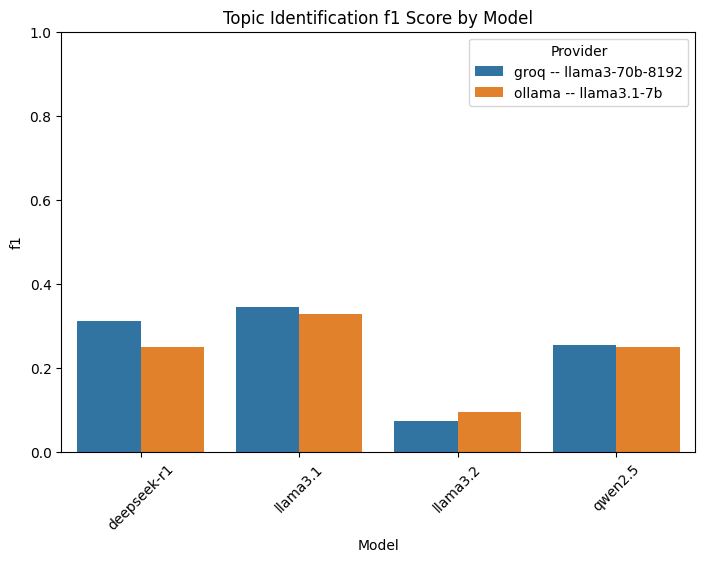

In [4]:
# Create visualizations
plt.figure(figsize=(18, 12))

# 1. Topic f1 by Model
plt.subplot(2, 2, 1)
sns.barplot(data=topic_summary, x='Model', y='f1', hue='Provider')
plt.title('Topic Identification f1 Score by Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Provider')

<Axes: xlabel='Model', ylabel='f1'>

Text(0.5, 1.0, 'Subtopic Identification f1 Score by Model')

(0.0, 1.0)

([0, 1, 2, 3],
 [Text(0, 0, 'deepseek-r1'),
  Text(1, 0, 'llama3.1'),
  Text(2, 0, 'llama3.2'),
  Text(3, 0, 'qwen2.5')])

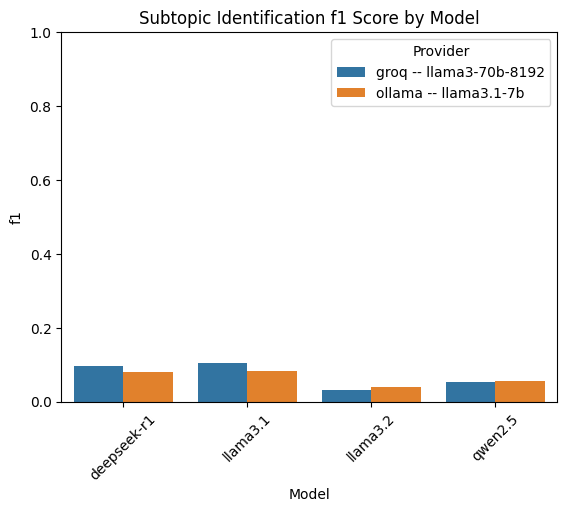

In [5]:
# 2. Subtopic f1 by Model
sns.barplot(data=subtopic_summary, x='Model', y='f1', hue='Provider')
plt.title('Subtopic Identification f1 Score by Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Provider')

<Axes: xlabel='Model', ylabel='f1'>

Text(0.5, 1.0, 'f1 Score by Presence of Forbidden Words')

(0.0, 1.0)

([0, 1, 2, 3],
 [Text(0, 0, 'deepseek-r1'),
  Text(1, 0, 'llama3.1'),
  Text(2, 0, 'llama3.2'),
  Text(3, 0, 'qwen2.5')])

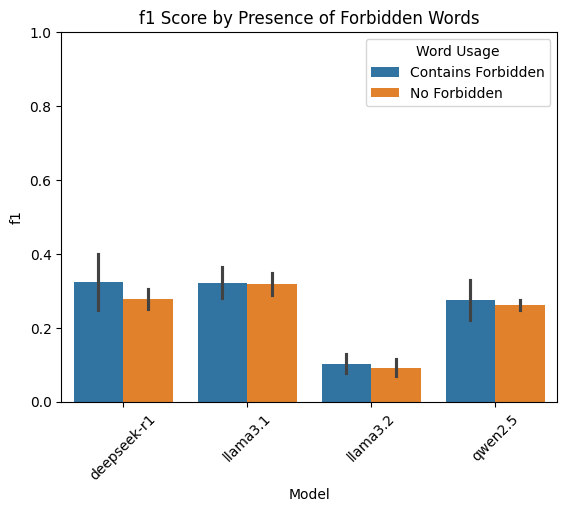

In [6]:
# 3. f1 Score With vs Without Forbidden Words
with_f1 = with_forbidden_summary[['Model', 'Provider', 'f1']].copy()
with_f1['Words'] = 'Contains Forbidden'
without_f1 = without_forbidden_summary[['Model', 'Provider', 'f1']].copy()
without_f1['Words'] = 'No Forbidden'
combined_f1 = pd.concat([with_f1, without_f1])
sns.barplot(data=combined_f1, x='Model', y='f1', hue='Words')
plt.title('f1 Score by Presence of Forbidden Words')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Word Usage')

<Axes: xlabel='Model', ylabel='f1'>

Text(0.5, 1.0, 'f1 Score by Presence of Subtopic Terms')

(0.0, 1.0)

([0, 1, 2, 3],
 [Text(0, 0, 'deepseek-r1'),
  Text(1, 0, 'llama3.1'),
  Text(2, 0, 'llama3.2'),
  Text(3, 0, 'qwen2.5')])

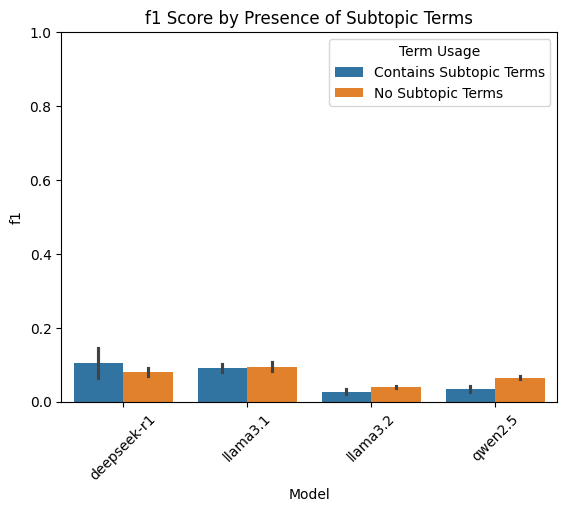

In [7]:
# 4. f1 Score With vs Without Subtopic Terms
with_sub_f1 = with_subtopic_summary[['Model', 'Provider', 'f1']].copy()
with_sub_f1['Terms'] = 'Contains Subtopic Terms'
without_sub_f1 = without_subtopic_summary[['Model', 'Provider', 'f1']].copy()
without_sub_f1['Terms'] = 'No Subtopic Terms'
combined_sub_f1 = pd.concat([with_sub_f1, without_sub_f1])
sns.barplot(data=combined_sub_f1, x='Model', y='f1', hue='Terms')
plt.title('f1 Score by Presence of Subtopic Terms')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Term Usage')